# **HAVOK study** | forcing characterization

*Ref*: [github@baronefr/havok-analysis](github.com/baronefr/havok-analysis)

In this notebook we show a sample of the havok analysis using our **rhavok library**.

In [1]:
from rhavok.havok import havok

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

from scipy import signal
from scipy.fft import fftshift

In [2]:
# color map used in this notebook
this_cm = plt.get_cmap('gist_rainbow')

#### Data import

We import the test dataset from a previously done HAVOK analysis.

In [3]:
data_path = './data/data_havok/'
vv = np.loadtxt(data_path + 'test_v.csv')
tt = np.loadtxt(data_path + 'test_t.csv')
xx = np.loadtxt(data_path + 'test_x.csv')

In [4]:
print(vv.shape[1], 'signatures available')

20 signatures available


### Visualize the embedded coordinates

In [5]:
# plot spectrum of embedded coordinates
def plot_embeddeb_spectrum(x, t, v,             # data
                  limit, selection = None,      # what to plot
                  vf = lambda x: x,             # transformation function for v
                  figsize = (10,9), alpha = 1): # aesthetics
    
    limit = np.arange(limit[0], limit[1])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[1,2]}, figsize=figsize, sharex=True)
    ax1.plot(t[limit], x[limit], c='k')
    ax1.set_ylabel('x(t)')
    
    if selection is None:
        selection = np.arange(2,v.shape[1]+1)
    elif isinstance(selection, int):
        selection = np.arange(2,selection+1)
    elif isinstance(selection, tuple):
        selection = np.arange(selection[0],selection[1]+1)
    elif isinstance(selection, list):
        pass
    selection = list(selection)
    
    ax2.set_prop_cycle( cycler( color=[this_cm(1.*i/len(selection)) for i in range(len(selection))] ))
    
    for ts in selection:
        ax2.plot(t[limit], vf(v[limit,ts-1]), label=str(ts), alpha=alpha)
    
    ax2.set_ylabel(r"$v_i(t)$")
    ax2.set_ylim([-.021,.021])
    ax2.legend()

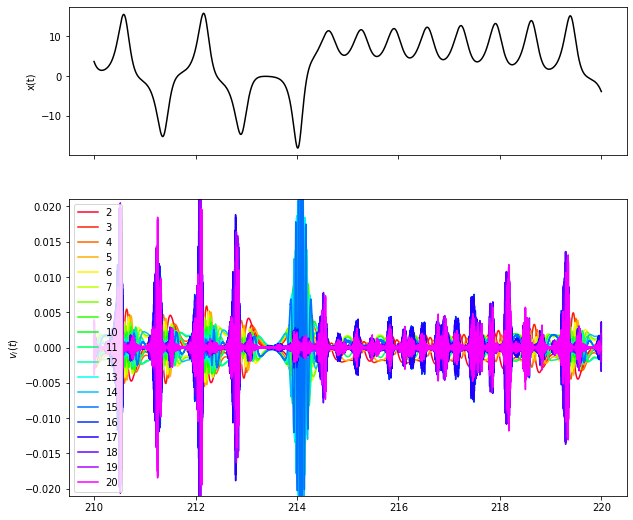

In [6]:
plot_embeddeb_spectrum(xx, tt, vv, [10000,20000])

## part 1 | hard thresholding

In [7]:
#  Activity criteria: create a cluster when forcing
# signal is greater than a threashold
def activity_by_threshold(forcing, thres = 0.002):
    
    above_thres = abs(forcing) > thres
    thres_expand = 500
    switch = False
    for i in range(0,len(above_thres)):
        if above_thres[i]:
            if not switch:
                above_thres[i:i+thres_expand] = True
                switch = True
        else:
            switch = False
    
    return above_thres

In [8]:
# roc curve for hard thresholding
def yaroc(obj, data, forcing, thres = 0.002):
    
    active_mask = activity_by_threshold(forcing, thres = thres)
    
    nswitch = 0
    ntrigger = 0
    tp = 0
    
    ntimeseries = len(forcing)
    prev_value = data[0]
    prev_trigger = False
    # let's walk though the timeseries
    for i in range(ntimeseries):
        if prev_value*data[i] <= 0:
            # there is a sign switch
            nswitch += 1
            if np.any(active_mask[(i-200):i]): tp += 1
            prev_value = data[i]
            
        if (active_mask[i] == True) and (prev_trigger == False): ntrigger += 1
        prev_trigger = active_mask[i]
    return tp, nswitch, ntrigger

In [9]:
# small demo on 15 th forcing term
tp, nsw, ntr = yaroc(None, xx, vv[:,14])
print("tpr = {}, fpr = {}".format( round(tp/nsw,3), round(1 - (tp/ntr),3)))
def_thres = (tp/nsw, 1 - (tp/ntr))

tpr = 0.961, fpr = 0.158


<br>

#### create ROC for rank = 15

In [10]:
def ROC(forcing, thr_test):
    tpr = np.empty(n)
    fpr = np.empty(n)
    for i, ths in enumerate(thr_test):
        tp, nsw, ntr = yaroc(None, xx[-len(forcing):], forcing, thres=ths)
        tpr[i] = tp/nsw
        if ntr == 0: fpr[i] = 0
        else: fpr[i] = 1 - (tp/ntr)
    return tpr, fpr

In [11]:
thr_test = np.arange(0.0001, 0.0251, 0.0001)
n = len(thr_test)
print("testing {} thresholds".format(n))

tpr, fpr = ROC(vv[:,14], thr_test)

testing 250 thresholds


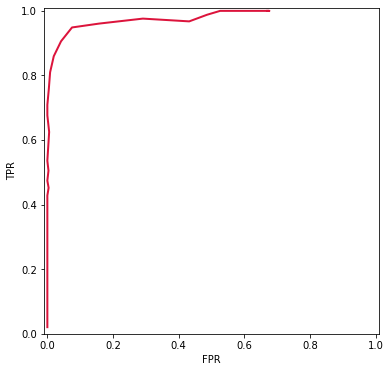

In [12]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2,c='crimson',label='ROC threshold')
plt.xlim([-.01,1.01])
plt.ylim([0,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

<br>

#### create ROC for more ranks

In [13]:
thr_test = np.arange(0.0001, 0.0251, 0.0001)
n = len(thr_test)
print("testing {} thresholds".format(n))

rank_test = [13, 14, 15, 16, 17, 18, 19, 20]
nr = len(rank_test)

print("testing {} ranks".format(nr))

testing 250 thresholds
testing 8 ranks


In [14]:
rocs = []
for rr in rank_test:
    print('testing rank', rr)
    tpr, fpr = ROC(vv[:,rr-1], thr_test)
    rocs.append( [tpr, fpr] )

testing rank 13
testing rank 14
testing rank 15
testing rank 16
testing rank 17
testing rank 18
testing rank 19
testing rank 20


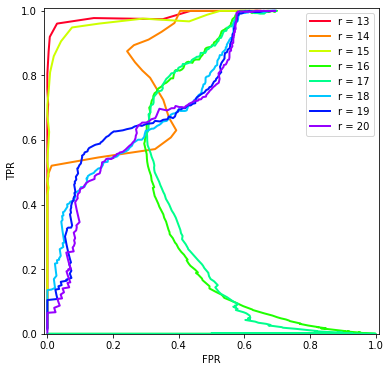

In [15]:
plt.figure(figsize=(6,6))

for i in range(nr):
    events = rocs[i]
    tpr = events[0]
    fpr = events[1]
    plt.plot(fpr,tpr, lw=2, c=this_cm(1.*i/nr), label=f'r = {rank_test[i]}')
    
plt.xlim([-.01,1.01])
plt.ylim([0,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

<br>

#### create ROC for more ranks on smoothed v

In [16]:
def moving_average(a, n=3):
    ret = np.cumsum(a, axis = 0, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

vsmooth = moving_average(vv, n=20)

(6000.0, 8000.0)

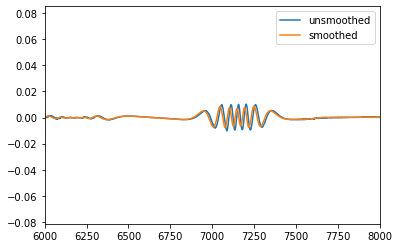

In [17]:
# compare the smoothing
plt.plot(vv[:,14], label = 'unsmoothed')
plt.plot(vsmooth[:,14], label = 'smoothed')
plt.legend()
plt.xlim([6000, 8000])

In [18]:
n = len(thr_test)
print("testing {} thresholds".format(n))

nr = len(rank_test)
print("testing {} ranks".format(nr))

testing 250 thresholds
testing 8 ranks


In [19]:
rocs_smooth = []
for rr in rank_test:
    print('testing rank', rr)
    tpr, fpr = ROC(vsmooth[:,rr-1], thr_test)
    rocs_smooth.append( [tpr, fpr] )

testing rank 13
testing rank 14
testing rank 15
testing rank 16
testing rank 17
testing rank 18
testing rank 19
testing rank 20


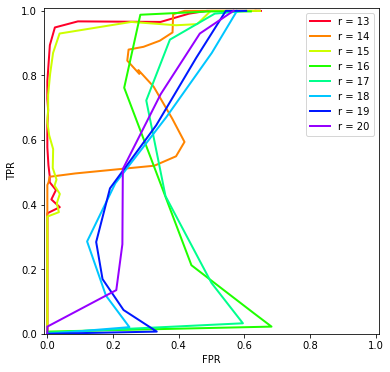

In [20]:
plt.figure(figsize=(6,6))

for i in range(nr):
    events = rocs_smooth[i]
    tpr = events[0]
    fpr = events[1]
    plt.plot(fpr,tpr, lw=2, c=this_cm(1.*i/nr), label=f'r = {rank_test[i]}')
    
plt.xlim([-.01,1.01])
plt.ylim([0,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [21]:
dfsdfdsfsf # stop here

NameError: name 'dfsdfdsfsf' is not defined

<br><br><br>

## other stuff

In [ ]:
plt.plot(smoothed)
plt.xlim([6000,8000])

In [ ]:
selsig = smoothed
n = len(selsig)
q = 100
mw = np.copy( selsig[:q] )

zcr = np.empty(n-q)
for i in range(n-q):
    zero_crosses = np.nonzero(np.diff(mw > 0))[0]
    zcr[i] = zero_crosses.size
    mw = np.roll(mw, -1)
    mw[-1] = selsig[q+i]

In [ ]:
plt.plot(zcr)
plt.xlim([6000,10000])

In [ ]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.plot(np.arange(n)*dt, selsig, color='black')
ax_right.plot((np.arange(len(zcr))+q)*dt, zcr, color='red')
ax_left.set_xlim([0,40])
ax_left.set_ylim([-.03,.03])

In [ ]:
conv = abs(selsig[:len(zcr)])*zcr
plt.plot((np.arange(n)*dt)[:len(zcr)], conv)
plt.xlim([0,40])

In [ ]:
plt.plot(np.arange(len(data))*dt, data)
plt.xlim([0,40])

***

Code by *Francesco Barone*, last review: 31 may 2022. <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele, Valentini Lorenzo.

University of Padua, **Laboratory of Computational Physics**, module B.